# 라이브러리 임포트

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

In [19]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

JC_IMAGE_FOLDER = './data/celeb/input_image/'

# 데이터 적재

In [20]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))
JC_csv = pd.read_csv(os.path.join(DATA_FOLDER, 'input.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])
JC_imageLoader = ImageLabelLoader(JC_IMAGE_FOLDER, INPUT_DIM[:2])


# 모델만들기

In [21]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

In [22]:
n_to_show=10
data_flow_generic = imageLoader.build(att, n_to_show)
JC_data_flow_generic = JC_imageLoader.build(JC_csv, n_to_show)

Found 202599 validated image filenames.
Found 1 validated image filenames.


# 새로 생성한 얼굴

In [23]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)
   
    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
       
        im = batch[0]
     
        attribute = batch[1]
    
        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]   
        z_NEG = z[attribute==-1]
    
        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist
        
        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector

In [24]:
def add_vector_to_images(feature_vec):

    n_to_show = 1
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    
    JC_example_batch = next(JC_data_flow_generic)
    JC_example_images = JC_example_batch[0]
    JC_example_labels = JC_example_batch[1]

    JC_z_points = vae.encoder.predict(JC_example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = JC_example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = JC_z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1
    
    plt.show()

In [25]:
BATCH_SIZE = 500
male_vec = get_vector_from_label('Male', BATCH_SIZE)
black_hair_vec= get_vector_from_label('Black_Hair', BATCH_SIZE)
blonde_hair_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)
brown_hair_vec= get_vector_from_label('Brown_Hair', BATCH_SIZE)
gray_hair_vec= get_vector_from_label('Gray_Hair', BATCH_SIZE)
straight_hair_vec= get_vector_from_label('Straight_Hair', BATCH_SIZE)
wavy_hair_vec= get_vector_from_label('Wavy_Hair', BATCH_SIZE)
heavy_makeup_vec= get_vector_from_label('Heavy_Makeup', BATCH_SIZE)
mustache_vec= get_vector_from_label('Mustache', BATCH_SIZE)
wearing_hat_vec= get_vector_from_label('Wearing_Hat', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
# print(r_loss.shape)
#print(example_batch)
#print(JC_example_batch)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Male
images : POS move : NEG move :distance : 𝛥 distance
214    : 1.155    : 1.008    : 1.749    : 1.749
412    : 0.65    : 0.532    : 1.516    : -0.233
610    : 0.369    : 0.338    : 1.428    : -0.088
834    : 0.304    : 0.249    : 1.383    : -0.045
1067    : 0.216    : 0.172    : 1.349    : -0.033
1268    : 0.162    : 0.146    : 1.307    : -0.043
1478    : 0.139    : 0.125    : 1.3    : -0.007
1702    : 0.14    : 0.108    : 1.281    : -0.019
1913    : 0.12    : 0.096    : 1.272    : -0.009
2116    : 0.096    : 0.086    : 1.266    : -0.006
2315    : 0.089    : 0.083    : 1.269    : 0.003
2527    : 0.087    : 0.069    : 1.263    : -0.006
2715    : 0.079    : 0.067    : 1.265    : 0.002
2920    : 0.071    : 0.065    : 1.273    : 0.008
3121    : 0.069    : 0.055    : 1.273    : -0.0
3349    : 0.065    : 0.053    : 1.27    : -0.003
3556    : 0.054    : 0.046    : 1.269    : -0.001
3759    : 0.055    : 0.053    : 1.265    : -0.003
3988    : 0.

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Black_Hair
images : POS move : NEG move :distance : 𝛥 distance
104    : 1.653    : 0.816    : 1.952    : 1.952
229    : 1.021    : 0.5    : 1.482    : -0.47
351    : 0.524    : 0.291    : 1.338    : -0.144
462    : 0.379    : 0.209    : 1.271    : -0.067
584    : 0.295    : 0.152    : 1.23    : -0.04
705    : 0.232    : 0.127    : 1.199    : -0.031
819    : 0.2    : 0.108    : 1.182    : -0.017
946    : 0.177    : 0.092    : 1.149    : -0.034
1080    : 0.171    : 0.082    : 1.125    : -0.024
1187    : 0.121    : 0.079    : 1.124    : -0.001
1328    : 0.134    : 0.055    : 1.119    : -0.005
1446    : 0.114    : 0.06    : 1.105    : -0.013
1576    : 0.105    : 0.055    : 1.092    : -0.014
1702    : 0.102    : 0.051    : 1.098    : 0.006
1829    : 0.086    : 0.05    : 1.081    : -0.017
1940    : 0.082    : 0.048    : 1.076    : -0.005
2065    : 0.08    : 0.045    : 1.072    : -0.004
2175    : 0.067    : 0.04    : 1.073    : 0.001
2298    : 0.

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
81    : 1.945    : 0.712    : 2.086    : 2.086
159    : 1.033    : 0.459    : 1.784    : -0.302
226    : 0.583    : 0.282    : 1.67    : -0.113
307    : 0.507    : 0.191    : 1.573    : -0.097
384    : 0.295    : 0.149    : 1.542    : -0.031
462    : 0.285    : 0.124    : 1.535    : -0.006
531    : 0.24    : 0.101    : 1.544    : 0.009
600    : 0.201    : 0.093    : 1.562    : 0.017
668    : 0.191    : 0.072    : 1.541    : -0.021
750    : 0.183    : 0.074    : 1.527    : -0.013
826    : 0.152    : 0.065    : 1.518    : -0.009
908    : 0.149    : 0.06    : 1.504    : -0.014
975    : 0.116    : 0.057    : 1.509    : 0.004
1043    : 0.114    : 0.048    : 1.486    : -0.023
1117    : 0.102    : 0.048    : 1.492    : 0.006
1190    : 0.104    : 0.045    : 1.487    : -0.004
1260    : 0.096    : 0.044    : 1.487    : -0.0
1336    : 0.097    : 0.041    : 1.48    : -0.007
1403    : 0.086

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Brown_Hair
images : POS move : NEG move :distance : 𝛥 distance
98    : 1.526    : 0.74    : 1.745    : 1.745
197    : 1.046    : 0.482    : 1.312    : -0.433
289    : 0.612    : 0.306    : 1.055    : -0.257
390    : 0.427    : 0.2    : 0.929    : -0.126
501    : 0.352    : 0.156    : 0.896    : -0.033
607    : 0.236    : 0.134    : 0.836    : -0.06
718    : 0.235    : 0.095    : 0.791    : -0.044
831    : 0.195    : 0.109    : 0.76    : -0.032
936    : 0.166    : 0.085    : 0.759    : -0.001
1045    : 0.147    : 0.072    : 0.747    : -0.012
1144    : 0.137    : 0.062    : 0.728    : -0.019
1251    : 0.128    : 0.06    : 0.704    : -0.024
1349    : 0.108    : 0.055    : 0.705    : 0.001
1456    : 0.11    : 0.048    : 0.703    : -0.002
1563    : 0.105    : 0.049    : 0.697    : -0.006
1671    : 0.088    : 0.047    : 0.685    : -0.012
1772    : 0.081    : 0.043    : 0.68    : -0.005
1869    : 0.071    : 0.039    : 0.672    : -0.007
1985    : 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Gray_Hair
images : POS move : NEG move :distance : 𝛥 distance
18    : 3.928    : 0.656    : 4.002    : 4.002
43    : 2.661    : 0.457    : 2.866    : -1.136
66    : 1.266    : 0.274    : 2.398    : -0.468
84    : 0.742    : 0.178    : 2.359    : -0.038
108    : 0.721    : 0.139    : 2.244    : -0.115
127    : 0.548    : 0.119    : 2.14    : -0.104
157    : 0.513    : 0.095    : 2.036    : -0.104
181    : 0.378    : 0.093    : 1.998    : -0.038
206    : 0.376    : 0.076    : 1.988    : -0.011
235    : 0.341    : 0.061    : 1.914    : -0.074
253    : 0.247    : 0.058    : 1.91    : -0.004
275    : 0.246    : 0.058    : 1.899    : -0.012
305    : 0.279    : 0.054    : 1.857    : -0.042
326    : 0.183    : 0.049    : 1.856    : -0.0
348    : 0.187    : 0.042    : 1.862    : 0.005
373    : 0.192    : 0.041    : 1.843    : -0.019
391    : 0.165    : 0.039    : 1.834    : -0.009
416    : 0.186    : 0.037    : 1.804    : -0.03
440    : 0.157    : 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Straight_Hair
images : POS move : NEG move :distance : 𝛥 distance
117    : 1.424    : 0.73    : 1.647    : 1.647
221    : 0.928    : 0.533    : 1.253    : -0.394
314    : 0.538    : 0.297    : 1.047    : -0.206
441    : 0.43    : 0.202    : 0.911    : -0.136
545    : 0.308    : 0.167    : 0.827    : -0.084
646    : 0.254    : 0.129    : 0.78    : -0.047
756    : 0.213    : 0.106    : 0.75    : -0.03
861    : 0.172    : 0.094    : 0.708    : -0.042
976    : 0.163    : 0.08    : 0.691    : -0.017
1079    : 0.128    : 0.073    : 0.658    : -0.032
1167    : 0.122    : 0.074    : 0.632    : -0.026
1281    : 0.123    : 0.063    : 0.63    : -0.002
1374    : 0.106    : 0.059    : 0.612    : -0.018
1468    : 0.097    : 0.056    : 0.604    : -0.008
1580    : 0.101    : 0.05    : 0.592    : -0.012
1696    : 0.101    : 0.045    : 0.59    : -0.002
1792    : 0.072    : 0.043    : 0.589    : -0.001
1896    : 0.079    : 0.044    : 0.575    : -0.014
2001  

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Wavy_Hair
images : POS move : NEG move :distance : 𝛥 distance
137    : 1.272    : 0.845    : 1.664    : 1.664
297    : 0.872    : 0.553    : 1.275    : -0.388
458    : 0.449    : 0.294    : 1.139    : -0.136
634    : 0.329    : 0.222    : 1.058    : -0.081
781    : 0.243    : 0.184    : 1.018    : -0.039
928    : 0.181    : 0.153    : 0.994    : -0.024
1090    : 0.159    : 0.114    : 0.975    : -0.019
1255    : 0.146    : 0.1    : 0.964    : -0.011
1410    : 0.129    : 0.091    : 0.946    : -0.018
1570    : 0.107    : 0.081    : 0.937    : -0.009
1720    : 0.101    : 0.071    : 0.933    : -0.003
1876    : 0.09    : 0.071    : 0.92    : -0.013
2026    : 0.081    : 0.06    : 0.919    : -0.002
2172    : 0.084    : 0.058    : 0.93    : 0.011
2317    : 0.079    : 0.054    : 0.924    : -0.006
2492    : 0.075    : 0.047    : 0.909    : -0.016
2650    : 0.074    : 0.047    : 0.903    : -0.006
2809    : 0.063    : 0.045    : 0.897    : -0.006
2970 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Heavy_Makeup
images : POS move : NEG move :distance : 𝛥 distance
183    : 1.252    : 0.901    : 1.732    : 1.732
383    : 0.683    : 0.564    : 1.507    : -0.226
581    : 0.382    : 0.323    : 1.361    : -0.145
792    : 0.324    : 0.228    : 1.289    : -0.072
986    : 0.204    : 0.197    : 1.228    : -0.061
1184    : 0.187    : 0.157    : 1.198    : -0.03
1378    : 0.14    : 0.131    : 1.175    : -0.023
1557    : 0.131    : 0.098    : 1.175    : 0.0
1763    : 0.119    : 0.092    : 1.154    : -0.021
1963    : 0.106    : 0.084    : 1.133    : -0.021
2118    : 0.079    : 0.083    : 1.13    : -0.003
2303    : 0.087    : 0.071    : 1.133    : 0.003
2490    : 0.077    : 0.067    : 1.132    : -0.001
2670    : 0.069    : 0.06    : 1.137    : 0.005
2859    : 0.072    : 0.055    : 1.148    : 0.011
3057    : 0.071    : 0.049    : 1.151    : 0.003
3253    : 0.06    : 0.046    : 1.145    : -0.006
3432    : 0.06    : 0.047    : 1.147    : 0.001
3630    

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Mustache
images : POS move : NEG move :distance : 𝛥 distance
23    : 3.203    : 0.674    : 3.275    : 3.275
48    : 2.158    : 0.455    : 2.322    : -0.954
68    : 1.07    : 0.255    : 1.948    : -0.374
83    : 0.695    : 0.185    : 1.858    : -0.09
101    : 0.678    : 0.146    : 1.826    : -0.032
115    : 0.486    : 0.11    : 1.691    : -0.135
138    : 0.528    : 0.1    : 1.598    : -0.093
161    : 0.417    : 0.085    : 1.615    : 0.017
183    : 0.372    : 0.084    : 1.541    : -0.074
202    : 0.339    : 0.073    : 1.486    : -0.055
217    : 0.25    : 0.064    : 1.418    : -0.068
234    : 0.25    : 0.058    : 1.435    : 0.017
260    : 0.269    : 0.049    : 1.398    : -0.038
281    : 0.238    : 0.047    : 1.353    : -0.044
296    : 0.195    : 0.045    : 1.323    : -0.03
323    : 0.236    : 0.037    : 1.317    : -0.006
351    : 0.2    : 0.033    : 1.298    : -0.019
369    : 0.157    : 0.033    : 1.297    : -0.001
394    : 0.19    : 0.034   

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Wearing_Hat
images : POS move : NEG move :distance : 𝛥 distance
19    : 3.897    : 0.604    : 3.958    : 3.958
44    : 2.574    : 0.468    : 2.593    : -1.365
60    : 1.101    : 0.257    : 2.333    : -0.261
84    : 1.01    : 0.17    : 2.191    : -0.141
106    : 0.683    : 0.134    : 2.07    : -0.121
132    : 0.621    : 0.107    : 1.976    : -0.095
162    : 0.555    : 0.095    : 1.861    : -0.115
185    : 0.424    : 0.091    : 1.86    : -0.001
217    : 0.433    : 0.082    : 1.857    : -0.002
241    : 0.317    : 0.066    : 1.854    : -0.003
263    : 0.235    : 0.064    : 1.841    : -0.013
288    : 0.281    : 0.051    : 1.839    : -0.002
311    : 0.22    : 0.05    : 1.829    : -0.011
333    : 0.221    : 0.052    : 1.833    : 0.004
359    : 0.215    : 0.044    : 1.828    : -0.005
378    : 0.184    : 0.043    : 1.824    : -0.004
401    : 0.172    : 0.037    : 1.824    : -0.0
431    : 0.179    : 0.038    : 1.808    : -0.016
457    : 0.16    : 0.

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
33    : 2.806    : 0.613    : 2.954    : 2.954
59    : 1.581    : 0.441    : 2.479    : -0.474
92    : 1.129    : 0.252    : 2.185    : -0.295
124    : 0.712    : 0.168    : 2.064    : -0.121
156    : 0.525    : 0.138    : 2.026    : -0.037
191    : 0.453    : 0.109    : 1.955    : -0.072
219    : 0.365    : 0.098    : 1.866    : -0.088
249    : 0.36    : 0.087    : 1.798    : -0.068
279    : 0.298    : 0.08    : 1.767    : -0.031
322    : 0.333    : 0.073    : 1.764    : -0.004
360    : 0.268    : 0.058    : 1.744    : -0.02
395    : 0.211    : 0.051    : 1.726    : -0.018
432    : 0.197    : 0.05    : 1.689    : -0.037
461    : 0.172    : 0.048    : 1.69    : 0.001
497    : 0.186    : 0.049    : 1.655    : -0.035
526    : 0.162    : 0.047    : 1.652    : -0.003
560    : 0.145    : 0.04    : 1.64    : -0.012
588    : 0.133    : 0.035    : 1.624    : -0.016
624    : 0.138    : 

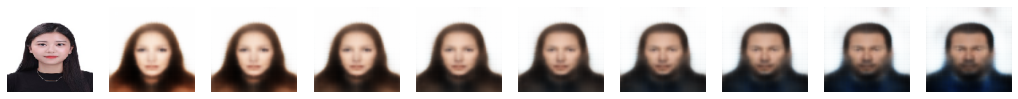

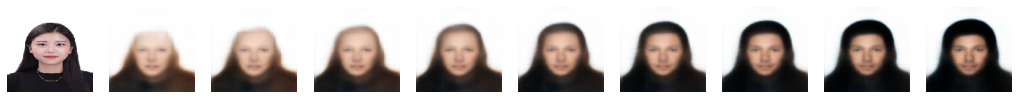

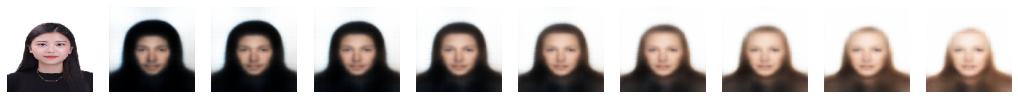

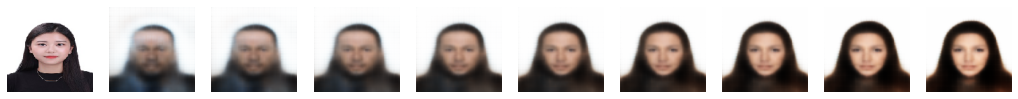

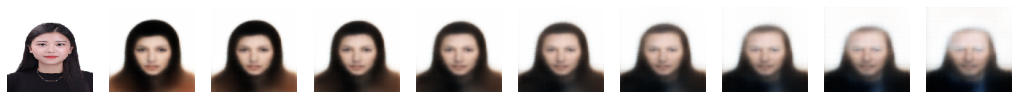

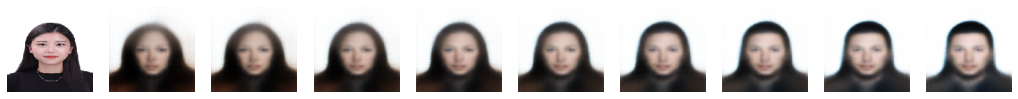

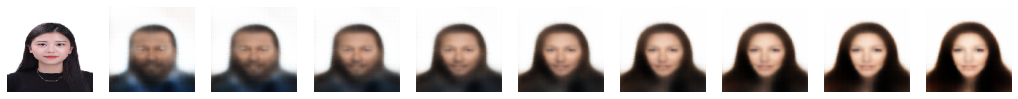

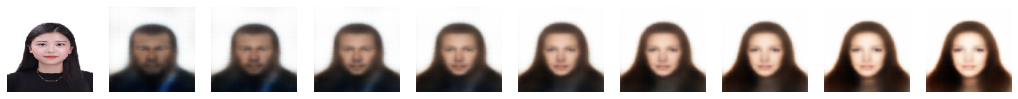

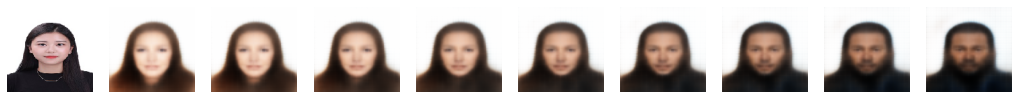

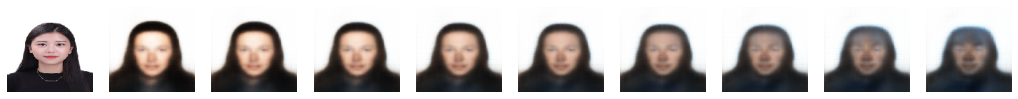

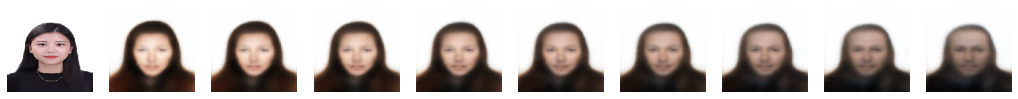

In [26]:
# print('Male Vector')
add_vector_to_images(male_vec)

# print('Blackhair Vector')
add_vector_to_images(black_hair_vec)

# print('Blondehair Vector')
add_vector_to_images(blonde_hair_vec)

# print('Brownhair Vector')
add_vector_to_images(brown_hair_vec)

# print('Grayhair Vector')
add_vector_to_images(gray_hair_vec)

# print('Straighthair Vector')
add_vector_to_images(straight_hair_vec)

# print('Wavy Vector')
add_vector_to_images(wavy_hair_vec)

# print('HeavyMakeUp Vector')
add_vector_to_images(heavy_makeup_vec)

# print('Mustache Vector')
add_vector_to_images(mustache_vec)

# print('Hat Vector')
add_vector_to_images(wearing_hat_vec)

# print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)